In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

import optuna

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [3]:
from params_manager import INTERNAL_PATH

seed = 142

In [4]:
import json

xbgs = []
with open('params/xbgs.json', 'r', encoding='utf-8') as f:
    xbgs = json.load(f)

cats = []
with open('params/cats.json', 'r', encoding='utf-8') as f:
    cats = json.load(f)

print(len(xbgs))
print(len(cats))

12
16


In [5]:
list(map(lambda x: x[1], xbgs))

[0.7582451102527966,
 0.7727479264970667,
 0.7826822221474002,
 0.783633275773886,
 0.7836607327526082,
 0.7839223957556721,
 0.7839470068285707,
 0.7840454511201645,
 0.78481961767059,
 0.7851191993625171,
 0.7851220452683408,
 0.7852052980344811]

In [6]:
list(map(lambda x: x[1], cats))

[0.7465176534344071,
 0.7621092891969415,
 0.7714642225546454,
 0.7782734731114008,
 0.7789253859609462,
 0.7798642142173439,
 0.7817162174945447,
 0.7822154134259415,
 0.782330211655227,
 0.7828836802131783,
 0.7829230418965437,
 0.7829814030075212,
 0.7833809521519056,
 0.7835172349660015,
 0.7839136576222978,
 0.7843146497611844]

In [7]:
params_xgb = list(reversed(list(map(lambda x: x[-1], xbgs[-7:]))))
params_cat = list(reversed(list(map(lambda x: x[-1], cats[-7:]))))

In [8]:
t = pd.read_csv(INTERNAL_PATH / 'train.csv')
t = t[t['outlier'] == 0].drop('outlier', axis=1)

X = t.drop('target', axis=1)
y = t['target']

cat_col = X.select_dtypes(include=['object']).columns.tolist()
X.shape

(63636, 167)

In [9]:
X_train_, X_test_, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=seed, stratify=y)
X_train = X_train_.copy().drop('user_id', axis=1)
X_test = X_test_.copy().drop('user_id', axis=1)

In [10]:
predictions = []
score = []

In [11]:
for i in tqdm(params_cat):
    catboost_model = CatBoostClassifier(**i)
    catboost_model.fit(X_train, y_train)
    predictions.append(catboost_model.predict_proba(X_test)[:, 1])
    _score = concordance_index(y_test, catboost_model.predict_proba(X_test)[:, 1])
    score.append(_score)
    print(_score)
    print('----------------------------------------------')

  0%|          | 0/7 [00:00<?, ?it/s]

0.783475067459993
----------------------------------------------
0.7826447042903433
----------------------------------------------
0.7835172349660015
----------------------------------------------
0.7833809521519056
----------------------------------------------
0.7823583500480197
----------------------------------------------
0.7828150578079631
----------------------------------------------
0.7828836802131783
----------------------------------------------


In [12]:
for i in tqdm(params_xgb):
    model_xgb = XGBClassifier(**i)
    model_xgb.fit(X_train.drop(cat_col, axis=1), y_train)
    predictions.append(model_xgb.predict_proba(X_test.drop(cat_col, axis=1))[:, 1])
    _score = concordance_index(y_test, model_xgb.predict_proba(X_test.drop(cat_col, axis=1))[:, 1])
    score.append(_score)
    print(_score)
    print('----------------------------------------------')

  0%|          | 0/7 [00:00<?, ?it/s]

0.7852052980344811
----------------------------------------------
0.7851220452683408
----------------------------------------------
0.7851191993625171
----------------------------------------------
0.78481961767059
----------------------------------------------
0.7840454511201645
----------------------------------------------
0.7839470068285707
----------------------------------------------
0.7839223957556721
----------------------------------------------


In [13]:
score

[0.783475067459993,
 0.7826447042903433,
 0.7835172349660015,
 0.7833809521519056,
 0.7823583500480197,
 0.7828150578079631,
 0.7828836802131783,
 0.7852052980344811,
 0.7851220452683408,
 0.7851191993625171,
 0.78481961767059,
 0.7840454511201645,
 0.7839470068285707,
 0.7839223957556721]

## SHAP

In [14]:
model_xgb2 = XGBClassifier(**xbgs[-1][-1])
model_xgb2.fit(X_train.drop(cat_col, axis=1), y_train)
concordance_index(y_test, model_xgb2.predict_proba(X_test.drop(cat_col, axis=1))[:, 1])

0.7852052980344811

In [15]:
import shap
explainer = shap.Explainer(model_xgb2)
shap_values = explainer(X_test.drop(cat_col, axis=1))

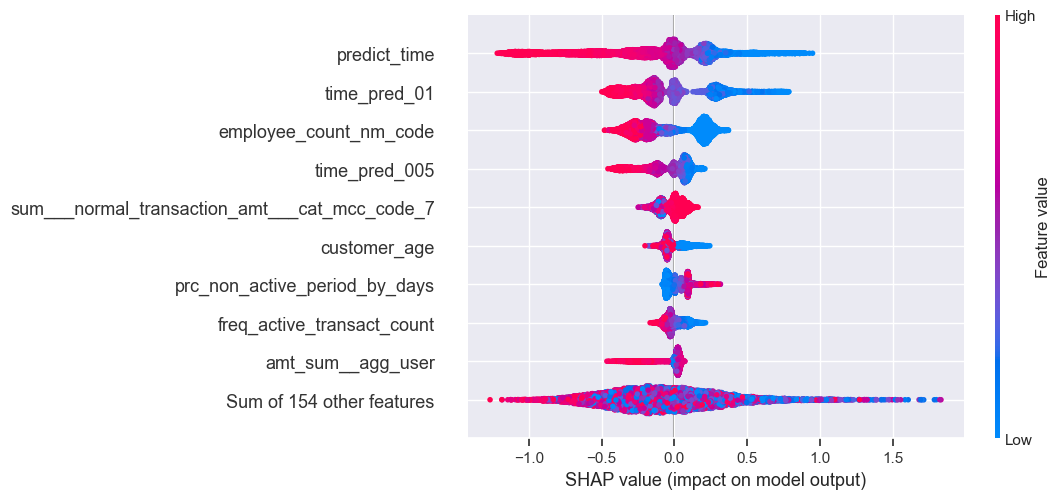

In [16]:
shap.plots.beeswarm(shap_values)

In [17]:
preds_xgb_ = model_xgb2.predict(X_test.drop(cat_col, axis=1))
preds_xgb2_ = model_xgb2.predict_proba(X_test.drop(cat_col, axis=1))[:, 1]

In [18]:
trans = pd.read_csv('data/transactions.csv')

1233
538675
(1, 0.7819286, 1)


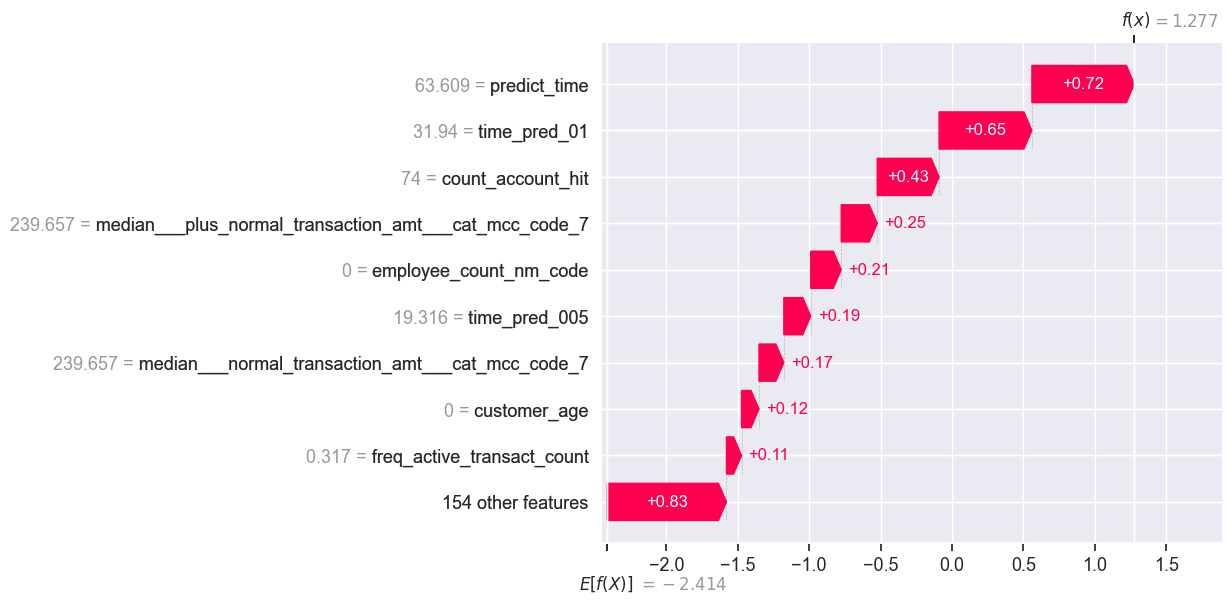

In [19]:
rand = np.random.randint(0, y_test.shape[0])
rand_ = 1233
print(rand_)
print(X_test_.iloc[rand_]['user_id'])
print((preds_xgb_[rand_], preds_xgb2_[rand_], y_test.iloc[rand_]))
shap.plots.waterfall(shap_values[rand_])

In [20]:
trans[trans['user_id'] == 538675]

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
12832871,538675,51,1,272.049896,2022-07-22 02:20:44
12832872,538675,2,1,-88.869537,2022-07-22 03:17:29
12832873,538675,2,1,-131.076019,2022-07-22 03:31:04
12832874,538675,51,1,91.475159,2022-07-23 16:15:34
12832875,538675,2,1,-60.400349,2022-07-24 06:00:20
...,...,...,...,...,...
12833106,538675,16,1,-314.835297,2023-01-13 21:59:26
12833107,538675,3,1,-1856.299561,2023-01-14 21:58:34
12833108,538675,2,1,-68.532684,2023-01-14 23:29:25
12833109,538675,3,1,-93.532570,2023-01-14 23:30:10


1077
112038
(0, 0.08472533, 0)


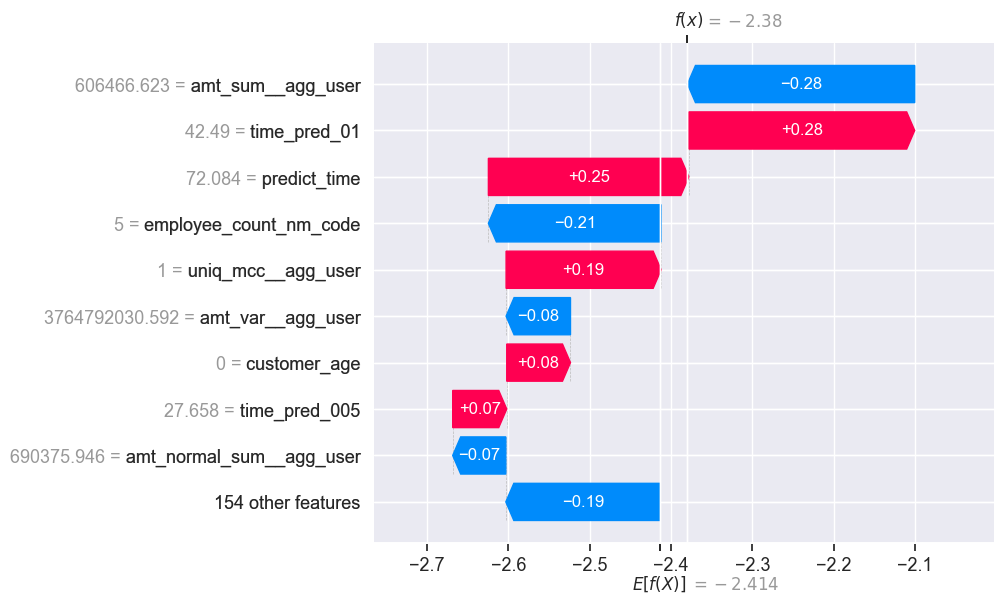

In [21]:
rand = np.random.randint(0, y_test.shape[0])
rand_ = 1077
print(rand_)
print(X_test_.iloc[rand_]['user_id'])
print((preds_xgb_[rand_], preds_xgb2_[rand_], y_test.iloc[rand_]))
shap.plots.waterfall(shap_values[rand_])

In [22]:
trans[trans['user_id'] == 112038]

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
2773012,112038,0,1,45144.468750,2022-09-17 18:39:03
2773013,112038,0,1,36539.011719,2022-10-06 23:33:10
2773014,112038,0,1,1376.908081,2022-10-07 19:10:03
2773015,112038,0,1,29012.656250,2022-11-16 13:43:05
2773016,112038,0,1,10557.026367,2022-11-16 13:45:27
2773017,112038,0,1,153672.812500,2022-12-13 17:35:55
2773018,112038,0,1,198738.718750,2022-12-13 17:44:45
2773019,112038,0,1,44336.660156,2022-12-13 17:46:14
2773020,112038,0,1,5314.372070,2022-12-13 18:08:48
2773021,112038,0,1,43571.566406,2023-01-16 19:49:47


8267
34220
(0, 0.007745449, 0)


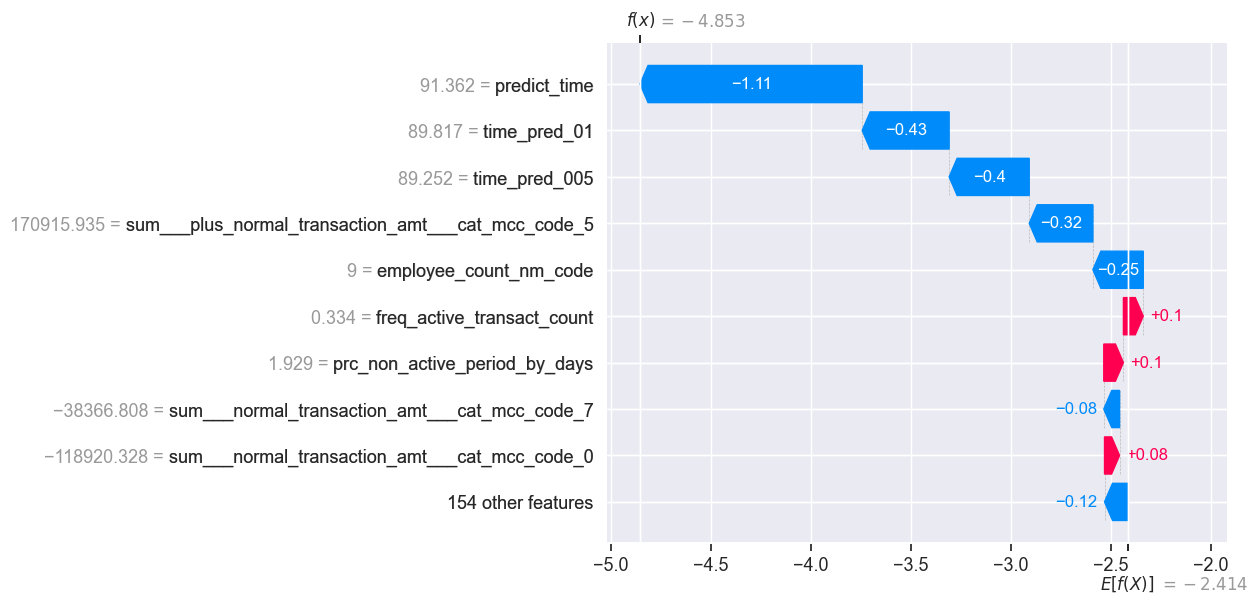

In [23]:
rand = np.random.randint(0, y_test.shape[0])
rand_ = rand
print(rand_)
print(X_test.iloc[rand_].name)
print((preds_xgb_[rand_], preds_xgb2_[rand_], y_test.iloc[rand_]))
shap.plots.waterfall(shap_values[rand_])

In [24]:
y_test1_ = y_test[y_test == 1]
y_test1 = y_test1_.reset_index()
y_test1.shape

(1070, 2)

In [25]:
X_test1 = X_test_.reset_index()
X_test1.shape

(12728, 168)

899
529260
(1, 0.656783, 1)


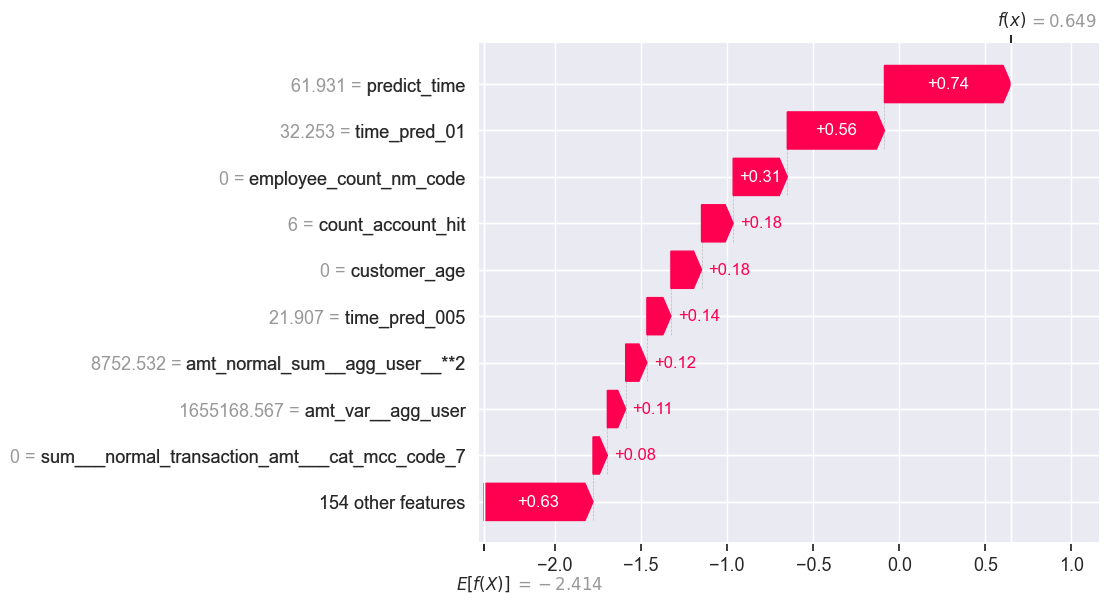

In [26]:
rand = np.random.randint(0, y_test1.shape[0])
rand_ = X_test1[X_test1['index'] == y_test1.iloc[rand]['index']].index[0] # 899
print(rand_)
print(X_test1.iloc[rand_]['user_id'])
print((preds_xgb_[rand_], preds_xgb2_[rand_], y_test.iloc[rand_]))
shap.plots.waterfall(shap_values[rand_])

## Creating an ensemble

In [27]:
from itertools import chain, combinations
def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(2, len(ss)+1)))

CIs = []
for subset in all_subsets(range(len(predictions))):
    preds = list(map(predictions.__getitem__, subset))
    ensemble_predictions = np.average(preds, axis=0)
    CIs.append((subset, concordance_index(y_test,  ensemble_predictions)))

CIs = sorted(CIs, key=lambda x: x[1], reverse=True)
len(CIs)

16369

In [28]:
CIs[:30]

[((2, 3, 7, 8, 9, 10), 0.7862800884395297),
 ((3, 9, 10), 0.7862768016187192),
 ((2, 3, 7, 9, 10), 0.7862547558693801),
 ((2, 3, 8, 9, 10), 0.7862372796026313),
 ((2, 3, 7, 9, 10, 12), 0.786234072948182),
 ((2, 3, 7, 8, 9, 10, 13), 0.7862236513212219),
 ((2, 3, 7, 9, 10, 13), 0.7862226091585258),
 ((2, 3, 7, 8, 9, 10, 12), 0.7862211661640236),
 ((2, 3, 8, 9, 10, 13), 0.7862071370508078),
 ((2, 3, 7, 8, 9), 0.7862056940563057),
 ((2, 3, 7, 8, 9, 12), 0.7862024072354951),
 ((2, 3, 8, 9, 10, 12), 0.7861982385847109),
 ((2, 3, 9, 10, 13), 0.7861874161259446),
 ((2, 3, 7, 9, 10, 12, 13), 0.7861802011534336),
 ((2, 3, 7, 8, 10), 0.7861780366616803),
 ((2, 3, 6, 7, 8, 9, 10, 12), 0.7861749101735922),
 ((3, 7, 9, 10), 0.786173787844535),
 ((2, 3, 7, 8, 9, 10, 12, 13), 0.7861710621882531),
 ((2, 3, 9, 10, 12), 0.786167935700165),
 ((2, 3, 7, 9, 12), 0.7861663323729403),
 ((2, 3, 7, 9, 13), 0.7861606405612928),
 ((2, 3, 6, 7, 8, 9, 10), 0.7861590372340681),
 ((2, 3, 9, 10), 0.7861585562359007),


In [29]:
nc = np.array(list(map(lambda x: x[1], CIs)))
len(nc[nc > 0.7862])

11

In [30]:
old_verbosity = optuna.logging.get_verbosity()
optuna.logging.set_verbosity(optuna.logging.WARNING)

best_CI = 0
best_subset = None
best_subsets = []
for (subset, CI) in CIs[:len(nc)]:
    preds = list(map(predictions.__getitem__, subset))
    def objective(trial):
        weights = []
        for i in range(len(preds)):
            weights.append(trial.suggest_float(f'weight_model{i}', 0.0, 1.0))
        
        ensemble_predictions = np.average(preds, axis=0, weights=weights)
        return concordance_index(y_test,  ensemble_predictions)

    study = optuna.study.create_study(direction='maximize')
    study.optimize(objective, n_trials=1000)
    if study.best_value > best_CI:
        best_CI = study.best_value
        best_subset = subset
        print(f'Best subset: {subset}')
        print(f'Best CI: {best_CI}')
        best_subsets.append((best_subset, best_CI))

# optuna.logging.set_verbosity(old_verbosity)

Best subset: (2, 3, 7, 8, 9, 10)
Best CI: 0.7863880725281104


In [31]:
_predictions6 = [predictions[2], predictions[3], predictions[7],
                predictions[8], predictions[9], predictions[10]]

def objective(trial):
    weights = []
    for i in range(len(_predictions6)):
        weights.append(trial.suggest_float(f'weight_model{i}', 0.0, 1.0))
    
    ensemble_predictions = np.average(_predictions6, axis=0, weights=weights)
    return concordance_index(y_test,  ensemble_predictions)

sqlite_db = "sqlite:///ensemble_sqlite_.db"
study_name = "ensemble_6"
study = optuna.create_study(storage=sqlite_db, study_name=study_name,
                            direction='maximize', load_if_exists=True)
study.optimize(objective, n_trials=3000)

best_weights = study.best_params

In [32]:
study.best_value

0.7863907180180311

In [33]:
weights6 = list(best_weights.values())
weights6

[0.27860926434922895,
 0.9647120760429382,
 0.22978832923289713,
 0.06763628303681603,
 0.7740909945334857,
 0.926802883636034]

In [34]:
predictions_6_sum = np.sum(np.array(weights6) * np.array(_predictions6).T, axis=1)

In [35]:
concordance_index(y_test, predictions_6_sum)

0.7863907180180311

## ROC

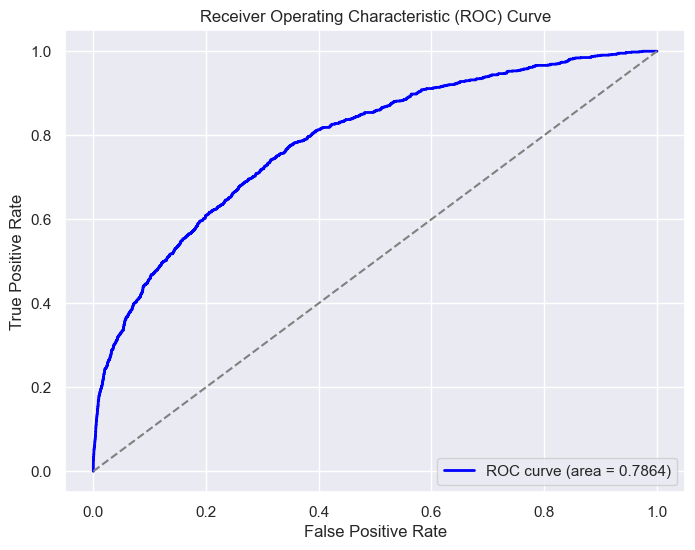

Best Threshold: 0.06877695158571126
Sensitivity (True Positive Rate) at best threshold: 0.7766355140186916
False Positive Rate at best threshold: 0.34963115457196775


In [36]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, np.average(_predictions6, axis=0, weights=weights6))

# Calculate the area under the ROC curve (ROC AUC)
roc_auc = roc_auc_score(y_test, np.average(_predictions6, axis=0, weights=weights6))

# Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Find the threshold that maximizes sensitivity and minimizes false positives
best_threshold_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_idx]
best_tpr = tpr[best_threshold_idx]
best_fpr = fpr[best_threshold_idx]

print("Best Threshold:", best_threshold)
print("Sensitivity (True Positive Rate) at best threshold:", best_tpr)
print("False Positive Rate at best threshold:", best_fpr)

## Youden's J statistic

In [37]:
# Calculate Youden's J statistic for each threshold
youden_j = tpr - fpr

best_threshold_idx = np.argmax(youden_j)
best_threshold = thresholds[best_threshold_idx]
best_tpr = tpr[best_threshold_idx]
best_fpr = fpr[best_threshold_idx]

print("Best Threshold:", best_threshold)
print("Sensitivity (True Positive Rate) at best threshold:", best_tpr)
print("False Positive Rate at best threshold:", best_fpr)

Best Threshold: 0.06877695158571126
Sensitivity (True Positive Rate) at best threshold: 0.7766355140186916
False Positive Rate at best threshold: 0.34963115457196775
